In [191]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

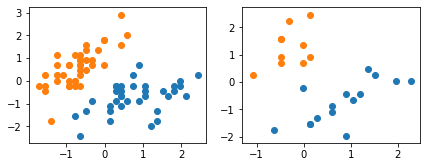

In [192]:
x, y = load_iris(return_X_y=True)

x, y = x.astype(np.float32), y.astype(np.float32)

x = x[:100, :2]
y = y[:100]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

scaler = StandardScaler()
scaler.fit(X_train)
# X_train, X_test = (X_train - mu) / std, (X_test - mu) / std
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1])
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1])
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1])
plt.show()

## Low-level implementation with manual gradients

In [193]:
class LogisticRegressionMannualGrad:
    def __init__(self, num_features):
        self.num_features = num_features
        
        self.W = np.random.randn(num_features, ) * 2 / num_features # he initialization
        self.b = 0
        
    def forward(self, x):
        logits = np.matmul(x, self.W) + self.b
        return self._sigmoid(logits)
    
    def backward(self, proba, y):
        error = y - proba
        return error
    
    def step(self, x, y, lr):
        proba = self.forward(x)
        error = self.backward(proba, y)
        
        self.W += lr * np.mean(error[..., None] * x, axis=0)
        self.b += lr * np.mean(error)
    def evaluate(self, x, y):
        proba = self.forward(x)
        labels = np.where(proba >= .5, 1, 0)
        return np.sum(labels == y) / len(y)
    
    
    def train(self, x, y, num_epochs, learning_rate=1e-1):
        for e in range(num_epochs):
            self.step(x, y, learning_rate)
            print('Epoch: %03d' % (e+1), end="")
            print(' | Train ACC: %.3f' % self.evaluate(x, y), end="")
            print(' | Test ACC: %.3f' % self.evaluate(X_test, y_test))
    
    def _sigmoid(self, z):
        return 1. / (1. + np.exp(-z))

In [194]:
LR = LogisticRegressionMannualGrad(2)

In [195]:
LR.train(X_train, y_train, 10, learning_rate=1e1)

Epoch: 001 | Train ACC: 0.987 | Test ACC: 1.000
Epoch: 002 | Train ACC: 1.000 | Test ACC: 1.000
Epoch: 003 | Train ACC: 1.000 | Test ACC: 1.000
Epoch: 004 | Train ACC: 1.000 | Test ACC: 1.000
Epoch: 005 | Train ACC: 1.000 | Test ACC: 1.000
Epoch: 006 | Train ACC: 1.000 | Test ACC: 1.000
Epoch: 007 | Train ACC: 1.000 | Test ACC: 1.000
Epoch: 008 | Train ACC: 1.000 | Test ACC: 1.000
Epoch: 009 | Train ACC: 1.000 | Test ACC: 1.000
Epoch: 010 | Train ACC: 1.000 | Test ACC: 1.000


In [196]:
LR.W

array([ 5.83512031, -4.08293108])

In [197]:
LR.b

-0.023162445708151486

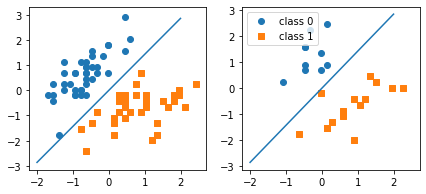

In [198]:
w, b = LR.W, LR.b

x_min = -2
y_min = ( (-(w[0] * x_min) - b) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

## Low-level implementation using tensorflow

In [211]:
class LogisticRegressionTF(tf.keras.Model):
    def __init__(self, num_features):
        super(LogisticRegressionTF, self).__init__()
        self.num_features = num_features
        
        w_init = tf.initializers.VarianceScaling(seed=1)
        self.W = tf.Variable(w_init(shape=(self.num_features, 1)), name='kernel')
        self.b = tf.Variable(0., name='bias')
        
    def call(self, x):
        z = tf.matmul(x, self.W) + self.b
        return tf.nn.sigmoid(z)

In [251]:
NUM_EPOCH = 10
LRTF = LogisticRegressionTF(2)
optimazer = tf.optimizers.SGD(learning_rate=1)

def loss_function(y, proba):
    return -y * tf.math.log(proba) - (1 - y) * tf.math.log(1 - proba)

for e in range(NUM_EPOCH):
    with tf.GradientTape() as tape:
        proba =LRTF(X_train)
        loss = tf.reduce_mean(loss_function(y_train, proba[:, 0]))
    variables = LRTF.variables
    gradients = tape.gradient(loss, variables)
    optimazer.apply_gradients(zip(gradients, variables))
    
    train_y_pred = tf.where(proba >= .5, 1, 0).numpy()
    train_acc = np.sum(train_y_pred[:, 0] == y_train) / len(y_train)
    
    test_y_pred = tf.where(LRTF(X_test)[:, 0] >= .5, 1, 0).numpy()
    test_acc = np.sum(test_y_pred == y_test) / len(y_test)
    
    print('Epoch: %03d' % (e+1), end="")
    print(' | Train ACC: %.3f' % train_acc, end="")
    print(' | Cost: %.3f' % loss.numpy(), end="")
    print(' | Test ACC: %.3f' % test_acc)

Epoch: 001 | Train ACC: 0.920 | Cost: 0.547 | Test ACC: 1.000
Epoch: 002 | Train ACC: 0.973 | Cost: 0.409 | Test ACC: 1.000
Epoch: 003 | Train ACC: 0.987 | Cost: 0.331 | Test ACC: 1.000
Epoch: 004 | Train ACC: 0.987 | Cost: 0.281 | Test ACC: 1.000
Epoch: 005 | Train ACC: 0.987 | Cost: 0.247 | Test ACC: 1.000
Epoch: 006 | Train ACC: 0.987 | Cost: 0.221 | Test ACC: 1.000
Epoch: 007 | Train ACC: 0.987 | Cost: 0.202 | Test ACC: 1.000
Epoch: 008 | Train ACC: 0.987 | Cost: 0.186 | Test ACC: 1.000
Epoch: 009 | Train ACC: 0.987 | Cost: 0.174 | Test ACC: 1.000
Epoch: 010 | Train ACC: 0.987 | Cost: 0.163 | Test ACC: 1.000


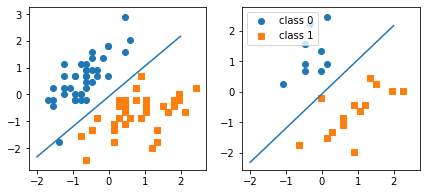

In [254]:
w, b = LRTF.W.numpy(), LRTF.b.numpy()

x_min = -2
y_min = ( (-(w[0] * x_min) - b) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()